In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [57]:
#some constants
au=1.6605*1e-27
hbar=1.054457*1e-34
g=9.8051
mDy=162*au
muB=9.274*1e-24
mu0=1.256637061*1e-6
muDy=10*muB
kB=1.3806*1e-23
gj=1.242 #landé factor for 162Dy gs 
gF=0.9463
#experimental constants
px=1.49e-6 #conversion px to μm
J=8#spin dimensionality
F=21/2
mJ=-np.arange(-J,J+1,1) #projections of Dy spin
mF=-np.arange(-F,F+1,1)

In [83]:
#Experimental parameters ##INPUT of the problem

gradB=10*1e-4/1e-2 #usual value for SG is 50, check the value for the non separating case, G/cm
deltaT=18e-3 #ToF, ms
T_i_x=510*1e-9 #temperature of the initial cloud in a single spin state, x (SG direction), nK
T_i_y=470*1e-9 # y, nK
T_ratio=T_i_x/T_i_y
T_f_x=810*1e-9 #Measured temperature after the 7 pulses, x, nK
T_f_y=630*1e-9 #y, nK
T_f_x_initial_condition=T_f_y*T_ratio
#initial size of the cloud, looked by eye on the notebook, so not very trust worthy, but also not very relevant
sigma_i_x=3*px 
sigma_i_y=3.8*px
sigma_f_x=3*px
sigma_f_y=5*px

In [81]:
#some math to extract the shift in position for mJ=8 if SG is applied
# formula for the force 
F=-gj*muB*mJ*gradB  #force acting of each spin state  due to the magnetic field gradient
#position of each spin component after deltaT tof
x=F/mDy*deltaT**2/2.
#perform a change of ref frame to one solidal to mj=-8 so that the state in mJ=-8 is stationary,this is the point in which the standard ToF is measured
F_gal=F-F[16]
#position of each spin component after deltaT tof, in the ref frame of mJ=-8
x_gal=F_gal/mDy*deltaT**2/2
print(x_gal*1e6)

[-34.25506374 -32.11412225 -29.97318077 -27.83223929 -25.6912978
 -23.55035632 -21.40941483 -19.26847335 -17.12753187 -14.98659038
 -12.8456489  -10.70470742  -8.56376593  -6.42282445  -4.28188297
  -2.14094148   0.        ]


In [121]:
#Calculation of the could size after tof (no SG considered, only reconstruction from the exp data)
#before the seven pulses
sigma_i_x_tof=np.sqrt(sigma_i_x**2+(T_i_x*kB/mDy)*deltaT**2)
sigma_i_y_tof=np.sqrt(sigma_i_y**2+(T_i_y*kB/mDy)*deltaT**2)
#after the seven pulses
sigma_f_x_tof=np.sqrt(sigma_f_x**2+(T_f_x*kB/mDy)*deltaT**2)
sigma_f_y_tof=np.sqrt(sigma_f_y**2+(T_f_y*kB/mDy)*deltaT**2)

In [123]:
figureToF=0
tt=np.linspace(0, 0.005,1000)
#creation of the plot data
sigma_x_f=np.sqrt((sigma_f_x)**2+(T_f_x*kB/mDy)*tt**2)
sigma_x_i=np.sqrt((sigma_i_x)**2+(T_i_x*kB/mDy)*tt**2)

sigma_y_f=np.sqrt(sigma_f_y**2+(T_f_y*kB/mDy)*tt**2)
sigma_y_i=np.sqrt(sigma_i_y**2+(T_i_y*kB/mDy)*tt**2)

if figureToF:
    fig, ax=plt.subplots()
    ax.plot(tt*1e3, sigma_x_f/px)
    ax.plot(tt*1e3, sigma_x_i/px)
    plt.xlabel(r'$t$ [ms]', fontsize=17)
    plt.ylabel(r'$\sigma_x$ [px]', fontsize=17)
    
    fig, ax2=plt.subplots()
    ax2.plot(tt*1e3, sigma_y_f/px)
    ax2.plot(tt*1e3, sigma_y_i/px)
    plt.xlabel(r'$t$ [ms]', fontsize=17)
    plt.ylabel(r'$\sigma_y$ [px]', fontsize=17)



    

Text(0.5, 1.0, 'ToF= 5 ms')

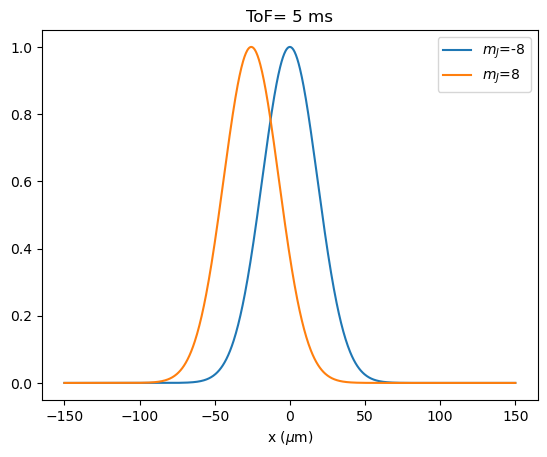

In [125]:
#plot of the distribution of mj=-8 and mj=8
xx=np.linspace(-150,150,1000)*1e-6
fig, ax4=plt.subplots()
ax4.plot(xx*1e6, np.exp(-xx**2/((sigma_i_x_tof)**2)),label=r'$m_J$=-8')
ax4.plot(xx*1e6, np.exp(-(xx-x_gal[0])**2/((sigma_i_x_tof)**2)),label=r'$m_J$=8')
ax4.legend()
plt.xlabel(r'x ($\mu$m)')
plt.title(r'ToF= 5 ms')

In [127]:
#function definitons for fitting, Gaussian and ToF and sigma as function of time
def fit_gauss(xxx, x0,sigma_fit, A):
    return A*np.exp(-(xxx-x0)**2/(sigma_fit)**2)

def ToF_fit(ttt, TT, s_i):
    return np.sqrt(s_i**2+(TT*kB/mDy)*ttt**2)

#T_exp_SG=T_f_x_initial_condition
T_exp_SG=0.76e-6
def sigma_t(ttt):
    return np.sqrt((sigma_f_x)**2+(T_exp_SG*kB/mDy)*ttt**2) #here I use the temperature measured for the 
                                             #direction perpendicular to the SG, optinally rescaled by the difference in the two temperatures before the Sd
                                                         #and the initial size of the vertical direction

In [129]:
#create vector of postion shift for mj=8 af fn of time
tfit=np.arange(0.,5.5e-3,0.5e-3)
x_gal_t=F_gal[0]/mDy*tfit**2/2.
#create the matrix for the gaussian evolultion in time
gauss_t=np.zeros((len(xx), len(tfit)))
#fill up the  matrix

for j in range(len(tfit)):
    for i in range(len(xx)):
        gauss_t[i,j]=np.exp(-(xx[i]-x_gal_t[j])**2/((sigma_t(tfit[j]))**2))+np.exp(-xx[i]**2/((sigma_t(tfit[j]))**2))

In [131]:
# graphic check that the gaussian has been built properly
figure_T=0
if figure_T:
    for j in range(len(tfit)):
        fig, ax5=plt.subplots()
        ax5.plot(xx*1e6,gauss_t[:,j])
        plt.xlabel(r'x ($\mu$m)')
        plt.title(r'ToF= 5 ms')

In [133]:
#fit of the guassians
sigma_fit=np.zeros(len(tfit))
Figure_gauss_fit=0

for j in range(len(tfit)):
    params, params_covariance = optimize.curve_fit(fit_gauss, xx*1e6 , gauss_t[:,j])
    sigma_fit[j]=params[1]*1e-6
    if Figure_gauss_fit:
        fig, ax10=plt.subplots()
        ax10.plot(xx*1e6,gauss_t[:,j])
        ax10.plot(xx*1e6,fit_gauss(xx*1e6, params[0],params[1], params[2]))
        plt.xlabel(r'x ($\mu$m)')
        plt.title(r'ToF= 5 ms')



8.961052244981589e-07 3.99504197719637e-06


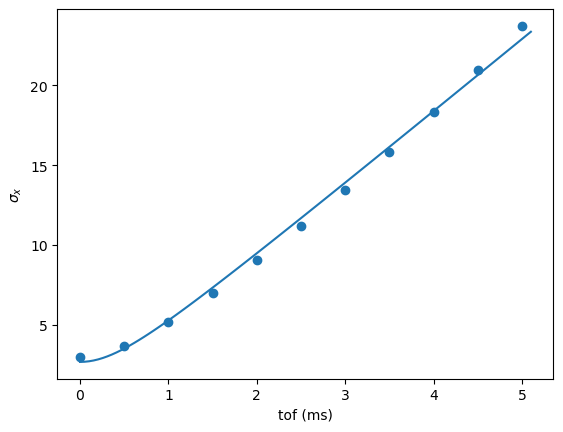

In [115]:
#fit of the tof


params2, params_covariance2 = optimize.curve_fit(ToF_fit, tfit, sigma_fit, p0=(630e-9,sigma_f_x),bounds=(0, 1))
taxis=np.linspace(0.,5.1e-3,100)
#plot of the sigma obtained and the fit of the fake tof
fig, ax6=plt.subplots()
ax6.scatter(tfit*1e3,sigma_fit/px)
ax6.plot(taxis*1e3,ToF_fit(taxis, params2[0],params2[1])/px )
plt.xlabel(r'tof (ms)')
plt.ylabel(r'$\sigma_x$')
#params2[0] is the temperature in K, params2[1] the initial size
print(params2[0], params2[1])

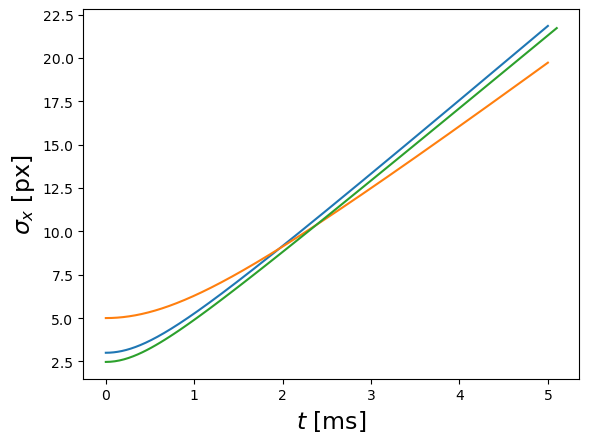

In [75]:
#final comparison with the original plot

fig, ax11=plt.subplots()
ax11.plot(tt*1e3, sigma_x_f/px, label='measured expansion x')
ax11.plot(tt*1e3, sigma_y_f/px, label='measured expansion y')
ax11.plot(taxis*1e3,ToF_fit(taxis, params2[0],params2[1])/px, label='simulated expansion in x with SG and T of y' )
plt.xlabel(r'$t$ [ms]', fontsize=17)
plt.ylabel(r'$\sigma_x$ [px]', fontsize=17);

In [85]:
#some math to extract the shift in position for mF= 21/2 if SG is applied
# formula for the force 
F=-gF*muB*mF*gradB  #force acting of each spin state  due to the magnetic field gradient
#position of each spin component after deltaT tof
x=F/mDy*deltaT**2/2.
#perform a change of ref frame to one solidal to mj=-8 so that the state in mJ=-8 is stationary,this is the point in which the standard ToF is measured
F_gal=F-F[21]
#position of each spin component after deltaT tof, in the ref frame of mJ=-8
x_gal=F_gal/mDy*deltaT**2/2
print(x_gal*1e6)

[-11098.80820235 -10570.29352605 -10041.77884974  -9513.26417344
  -8984.74949714  -8456.23482084  -7927.72014453  -7399.20546823
  -6870.69079193  -6342.17611563  -5813.66143933  -5285.14676302
  -4756.63208672  -4228.11741042  -3699.60273412  -3171.08805781
  -2642.57338151  -2114.05870521  -1585.54402891  -1057.0293526
   -528.5146763       0.        ]
